<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

**Описание данных**

**Признаки:**
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

**Целевой признак**
- Exited — факт ухода клиента

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Проверим на явные дубликаты

In [5]:
df.duplicated().sum()

0

**Вывод**
- В данных присутствуют пропуски, в столбце Tenure
- Избавимся от пропусков
- В данных присутствуют столбцы с информацией, которая не нужна модели для обучения: RowNumber, EstimatedSalary, CustomerId, Surname
- Удалим столбцы ненужные для обучения
- Удалим явные дубликаты

In [6]:
df= df.drop_duplicates()

Некоректное заполнение может исказить данные, поэтому стоит сравнить харарктеристики распределения(mean, std, median) до и после заполнения

In [7]:
fillna_const =df['Tenure'].fillna(0)
print('base std', df['Tenure'].std())
print('base median', df['Tenure'].median())
print('base mean', df['Tenure'].mean())
print('fillna 0 std', fillna_const.std())
print('fillna 0 median', fillna_const.median())
print('fillna 0 mean', fillna_const.mean())

fillna_median = df['Tenure'].fillna(df['Tenure'].median())
print('fillna_median std', fillna_median.std())
print('fillna_median median', fillna_median.median())
print('fillna_median mean', fillna_median.mean())

base std 2.894723234821247
base median 5.0
base mean 4.997690023099769
fillna 0 std 3.111572693745535
fillna 0 median 4.0
fillna 0 mean 4.5434
fillna_median std 2.760010390512248
fillna_median median 5.0
fillna_median mean 4.9979


Замена на нулевое значение исказит данные, лучше всего использовать замену на медийное значение и перевести формат столбца в целые числа

In [8]:
df['Tenure']=df['Tenure'].fillna(df['Tenure'].median()).astype('int64')

RowNumber — индекс строки дублирует информацию стандартного датафрейма, можно удалить

CustomerId — идентификатор пользователя для обучения модели не нужен

Surname — Фамилии тоже выступают как является идентификатор пользователя с уникальными значениями, его наличие усложнит обучение модели

EstimatedSalary — предполагаемая зарплата остается предполагаемыми значениями, во много индивидуальны, что тоже усложнит построение модели

In [9]:
drops=['RowNumber','EstimatedSalary','CustomerId','Surname']
df=df.drop(drops,axis=1)

Убрали пропуски, перевели данные в целые числа, удалили ненужные столбцы, теперь проверим данные повторно

In [10]:
df.duplicated().sum()

1

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CreditScore     10000 non-null  int64  
 1   Geography       10000 non-null  object 
 2   Gender          10000 non-null  object 
 3   Age             10000 non-null  int64  
 4   Tenure          10000 non-null  int64  
 5   Balance         10000 non-null  float64
 6   NumOfProducts   10000 non-null  int64  
 7   HasCrCard       10000 non-null  int64  
 8   IsActiveMember  10000 non-null  int64  
 9   Exited          10000 non-null  int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 859.4+ KB


In [12]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,Exited
0,619,France,Female,42,2,0.00,1,1,1,1
1,608,Spain,Female,41,1,83807.86,1,0,1,0
2,502,France,Female,42,8,159660.80,3,1,0,1
3,699,France,Female,39,1,0.00,2,0,0,0
4,850,Spain,Female,43,2,125510.82,1,1,1,0


**Вывод 1 Подготовка данных**

В данных присутствовали явные дубликаты, пропуски и ненужные столбцы, после предобработки данные приведены в порядок и готовы к дальнейшему построению моделей

## Исследование задачи

Задача звучит как: "Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет."

Следовательно, клиенты и данны делятся на тех кто ушел и тех кто остался.

Эта информация содержится в столбце "Exited" (факт ухода клиента), что является нашим целевым признаком будущей модели обучения

Подготовим данные для машинного обучения

Данные подготовим методом One hot encoder, что позволит нам не попасться в дамми ловушку

In [13]:
df.shape

(10000, 10)

In [14]:
df=pd.get_dummies(df,drop_first=True)

In [15]:
df.shape

(10000, 11)

В новом датасете количество столбцов увеличелост на 1:
- Geography разделился на Geography_Germany, Geography_Spain 
- А столбец Gender стал Gender_Male и содержит 2 класса (0 и 1)

**Разбиваем данные на выборки**

**Исходные данные разбивают в соотношении 3:1:1**
- Обучающая выборка (features_train, target_train) 60%
- Валидационая выборка (features_valid, target_valid) 20%
- Тестовая выборка (features_test, target_test) 20%

In [16]:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=12345)
features = df_test.drop('Exited', axis=1)
target = df_test['Exited']
features_valid, features_test, target_valid, target_test = train_test_split(features, target, test_size=0.5, random_state=12345)
features_train = df_train.drop('Exited', axis=1)
target_train = df_train['Exited']

**Скалирование:**
- для масштабирования методом scaler выделим численные признаки
- численные признаки разной величины
- стандатризируем наши выборки

In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

/tmp/ipykernel_86/797183956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[numeric] = scaler.transform(features_valid[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_86/797183956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [18]:
print(features_train.head())

      CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
7479    -0.886751 -0.373192  1.082277  1.232271      -0.891560          1   
3411     0.608663 -0.183385  1.082277  0.600563      -0.891560          0   
6027     2.052152  0.480939 -0.737696  1.027098       0.830152          0   
1247    -1.457915 -1.417129  0.354288 -1.233163       0.830152          1   
3716     0.130961 -1.132419 -1.101690  1.140475      -0.891560          0   

      IsActiveMember  Geography_Germany  Geography_Spain  Gender_Male  
7479               0                  0                1            1  
3411               0                  0                0            0  
6027               1                  1                0            1  
1247               0                  0                0            1  
3716               0                  1                0            0  


**Исследуйте модели**

**Смена гиперпараметров**

Самый важный гиперпараметр решающего дерева — max_depth. Настроим его для нашего дерева решений, на основании F1-меры.

In [19]:
for depth in range(1, 10):
    model_DTC = DecisionTreeClassifier(random_state=12345, max_depth = depth) 
    model_DTC.fit(features_train,target_train) 
    predictions_valid = model_DTC.predict(features_valid)

    print('max_depth =', depth, ',F1 =',f1_score(target_valid, predictions_valid))

max_depth = 1 ,F1 = 0.0
max_depth = 2 ,F1 = 0.5217391304347825
max_depth = 3 ,F1 = 0.4234875444839857
max_depth = 4 ,F1 = 0.5454545454545454
max_depth = 5 ,F1 = 0.534375
max_depth = 6 ,F1 = 0.5658093797276854
max_depth = 7 ,F1 = 0.5521472392638037
max_depth = 8 ,F1 = 0.5465288035450516
max_depth = 9 ,F1 = 0.5479833101529902


**Вывод: лучший параметр Дерева Решений max_depth = 6 ,F1 = 0.5658093797276854**

In [20]:
for depth in range(1, 20):
    model_RFC = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=50) 
    model_RFC.fit(features_train,target_train) 
    predictions_valid = model_RFC.predict(features_valid) 
    
    print('max_depth =', depth, ',F1 =',f1_score(target_valid,predictions_valid))

max_depth = 1 ,F1 = 0.0
max_depth = 2 ,F1 = 0.1849462365591398
max_depth = 3 ,F1 = 0.26175869120654394
max_depth = 4 ,F1 = 0.36466165413533835
max_depth = 5 ,F1 = 0.5041736227045075
max_depth = 6 ,F1 = 0.5650793650793651
max_depth = 7 ,F1 = 0.5541401273885351
max_depth = 8 ,F1 = 0.5830721003134797
max_depth = 9 ,F1 = 0.5806451612903226
max_depth = 10 ,F1 = 0.5740740740740741
max_depth = 11 ,F1 = 0.5775075987841946
max_depth = 12 ,F1 = 0.5705705705705705
max_depth = 13 ,F1 = 0.5701492537313433
max_depth = 14 ,F1 = 0.5905044510385756
max_depth = 15 ,F1 = 0.5970588235294118
max_depth = 16 ,F1 = 0.5868613138686132
max_depth = 17 ,F1 = 0.5850144092219021
max_depth = 18 ,F1 = 0.5846599131693199
max_depth = 19 ,F1 = 0.5847953216374269


**Вывод: лучший параметр Случайного леса max_depth = 15 ,F1 = 0.5970588235294118**

In [21]:
for estim in range(1,50,1):
    model_RFC = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=estim) 
    model_RFC.fit(features_train,target_train) 
    predictions_valid = model_RFC.predict(features_valid)
    
    print('estim:',estim, ',F1 =',f1_score(target_valid,predictions_valid))

estim: 1 ,F1 = 0.49110320284697506
estim: 2 ,F1 = 0.444104134762634
estim: 3 ,F1 = 0.5173333333333333
estim: 4 ,F1 = 0.47619047619047616
estim: 5 ,F1 = 0.5138888888888888
estim: 6 ,F1 = 0.5141158989598811
estim: 7 ,F1 = 0.544179523141655
estim: 8 ,F1 = 0.5352941176470588
estim: 9 ,F1 = 0.5605633802816901
estim: 10 ,F1 = 0.5561959654178675
estim: 11 ,F1 = 0.5637393767705382
estim: 12 ,F1 = 0.5677233429394813
estim: 13 ,F1 = 0.5697841726618705
estim: 14 ,F1 = 0.5689149560117303
estim: 15 ,F1 = 0.5843023255813955
estim: 16 ,F1 = 0.5784883720930232
estim: 17 ,F1 = 0.5855072463768116
estim: 18 ,F1 = 0.5814977973568282
estim: 19 ,F1 = 0.5999999999999999
estim: 20 ,F1 = 0.5970588235294118
estim: 21 ,F1 = 0.5933429811866859
estim: 22 ,F1 = 0.5903083700440529
estim: 23 ,F1 = 0.5997088791848617
estim: 24 ,F1 = 0.5905044510385756
estim: 25 ,F1 = 0.5959302325581396
estim: 26 ,F1 = 0.5941176470588235
estim: 27 ,F1 = 0.5938864628820961
estim: 28 ,F1 = 0.5941176470588235
estim: 29 ,F1 = 0.59011627906

**Вывод: лучший параметрestim: estim: 45 ,F1 = 0.6032210834553441**

Мы получили масштабированные признаки для трех выборок. Теперь пмотрим на модели без баланса классов, указав лучший гиперпараметр

In [22]:
model_DTC = DecisionTreeClassifier(random_state=12345, max_depth = 6)
model_DTC.fit(features_train, target_train)

prediction_DTC=model_DTC.predict(features_valid)
DTC_score = model_DTC.score(features_test, target_test)
f1_DTC = f1_score(target_valid,prediction_DTC)

probabilities_valid_DTC = model_DTC.predict_proba(features_valid)
probabilities_one_valid_DTC = probabilities_valid_DTC[:, 1]
auc_roc_DTC = roc_auc_score(target_valid, probabilities_one_valid_DTC)

print('Дерево решений')
print('F1 мера:',f1_DTC)
print('Точность:',DTC_score)
print('Полнота:',recall_score(target_valid, prediction_DTC))
print('AUC-ROC:', auc_roc_DTC)

Дерево решений
F1 мера: 0.5658093797276854
Точность: 0.849
Полнота: 0.4473684210526316
AUC-ROC: 0.8256393699453783


In [23]:
model_RFC = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=45)
model_RFC.fit(features_train, target_train)

prediction_RFC=model_RFC.predict(features_valid)
RFC_score = model_RFC.score(features_test, target_test)
f1_RFC = f1_score(target_valid,prediction_RFC)

probabilities_valid_RFC = model_RFC.predict_proba(features_valid)
probabilities_one_valid_RFC = probabilities_valid_RFC[:, 1]
auc_roc_RFC = roc_auc_score(target_valid, probabilities_one_valid_RFC)

print('Случайный лес')
print('F1 мера:',f1_RFC)
print('Точность:',RFC_score)
print('Полнота:',recall_score(target_valid, prediction_RFC))
print('AUC-ROC:', auc_roc_RFC)

Случайный лес
F1 мера: 0.6032210834553441
Точность: 0.847
Полнота: 0.49282296650717705
AUC-ROC: 0.8408009666160574


In [24]:
model_LR = LogisticRegression(solver = 'liblinear')
model_LR.fit(features_train, target_train)

prediction_LR=model_LR.predict(features_valid)
LR_score = model_LR.score(features_test, target_test)
f1_LR = f1_score(target_valid,prediction_LR)

probabilities_valid_LR = model_LR.predict_proba(features_valid)
probabilities_one_valid_LR = probabilities_valid_LR[:, 1]
auc_roc_LR = roc_auc_score(target_valid, probabilities_one_valid_LR)

print('Логистческая регрессия')
print('F1 мера:',f1_LR)
print('Точность:',LR_score)
print('Полнота:',recall_score(target_valid, prediction_LR))
print('AUC-ROC:', auc_roc_LR)

Логистческая регрессия
F1 мера: 0.3395585738539898
Точность: 0.7905
Полнота: 0.23923444976076555
AUC-ROC: 0.7586212111130601


Построим на диаграмму и значения баланса классов

0    0.800667
1    0.199333
Name: Exited, dtype: float64

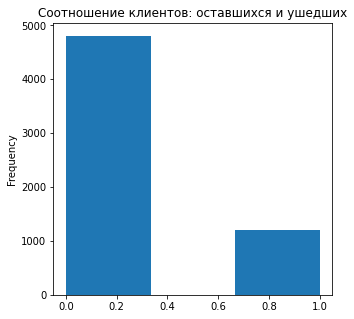

In [25]:
target_train.plot(kind ='hist', bins=3, figsize=(5,5),title='Соотношение клиентов: оставшихся и ушедших');
target_train.value_counts(normalize = 1)

С увереностью можем сказать, что видим дисбаланс. Отрицательных ответов 80%, а положительных всего 20%

Посмотрим соотношение на каждой модели

In [26]:
model_DTC = DecisionTreeClassifier(random_state=12345, max_depth = 6)
model_DTC.fit(features_train, target_train)
DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
print("Дерево решений. Доли ответов:", DTC_share)

Дерево решений. Доли ответов: 0    0.8785
1    0.1215
dtype: float64


In [27]:
model_RFC = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=45)
model_RFC.fit(features_train, target_train)
RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
print("Случайный лес. Доли ответов:", RFC_share)

Случайный лес. Доли ответов: 0    0.8675
1    0.1325
dtype: float64


In [28]:
model_LR = LogisticRegression(solver = 'liblinear')
model_LR.fit(features_train, target_train)
LR_share = pd.Series(model_LR.predict(features_valid)).value_counts(normalize = 1)
print("Логистческая регрессия. Доли ответов:", LR_share)

Логистческая регрессия. Доли ответов: 0    0.9145
1    0.0855
dtype: float64


**Вывод**

Рассматрев датасет с дисбалансом, используя три модели с лучшими гиперпараметрами можно сделать вывод, что саммая лучшая модель оказалась Случайный лес. 

При лучшем значении max_depth=15 и n_estimators=45 мы имеем F1 мера: 0.6032210834553441
и Точность: 0.847 на валидной выборке.

Однако существует дисбаланс 80% - это отрицательные ответы

## Борьба с дисбалансом

Нам известно о существовании дисбаланса в выборке, приблизительно отрицательных ответов 80%, а положительных всего 20%.

Для решения данной проблемы нужно либо увеличить количество положительных ответов, либо уменьшить количество отрицательных

В этом нам помогут техники upsampling и downsampling, взглянем на них и сравним

**Сделаем объекты редкого класса не такими редкими в данных, техникой upsampling**

Преобразование проходит в несколько этапов:
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.

In [29]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
score = model.score(features_valid, target_valid)

print(target_upsampled.value_counts(normalize = 1))
print(target_upsampled.shape)

0    0.501043
1    0.498957
Name: Exited, dtype: float64
(9588,)


0    0.501043
1    0.498957
Name: Exited, dtype: float64

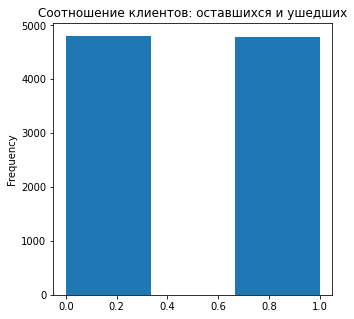

In [30]:
target_upsampled.plot(kind ='hist', bins=3, figsize=(5,5),title='Соотношение клиентов: оставшихся и ушедших');
target_upsampled.value_counts(normalize = 1)

**Сделаем объекты частого класса не такими частыми, техникой downsampling**

Преобразование проходит в несколько этапов:
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Случайным образом отбросить часть из отрицательных объектов;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

In [31]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
score = model.score(features_valid, target_valid)

print(target_downsampled.value_counts(normalize = 0))
print(target_downsampled.shape)

0    1201
1    1196
Name: Exited, dtype: int64
(2397,)


0    0.501043
1    0.498957
Name: Exited, dtype: float64

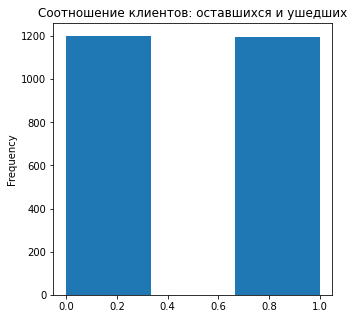

In [32]:
target_downsampled.plot(kind ='hist', bins=3, figsize=(5,5),title='Соотношение клиентов: оставшихся и ушедших');
target_downsampled.value_counts(normalize = 1)

**Вывод**

На гистограмме upsampling видно почти идеальное распределения ответов, по сравнению с техникой downsampling. 

По данным моделям, в дальнейшем будем работать с техникой upsampling

## Тестирование модели

**После балансирования модели подбираем новые лучшие гиперпараметры**

In [33]:
%%time

for depth in range(1,20,1):
    model_DTC_upsampled=DecisionTreeClassifier(max_depth=depth,random_state=12345)
    model_DTC_upsampled.fit(features_upsampled, target_upsampled)
  
    predictions_valid=model_DTC_upsampled.predict(features_valid)
    print('max_depth:',depth,'F1:',f1_score(target_valid,predictions_valid))

max_depth: 1 F1: 0.4994903160040775
max_depth: 2 F1: 0.541015625
max_depth: 3 F1: 0.541015625
max_depth: 4 F1: 0.5277777777777778
max_depth: 5 F1: 0.5938494167550372
max_depth: 6 F1: 0.5582255083179298
max_depth: 7 F1: 0.5557851239669421
max_depth: 8 F1: 0.5442043222003929
max_depth: 9 F1: 0.5373423860329777
max_depth: 10 F1: 0.5143992055610724
max_depth: 11 F1: 0.5168067226890757
max_depth: 12 F1: 0.49278350515463915
max_depth: 13 F1: 0.5043668122270742
max_depth: 14 F1: 0.4869169510807736
max_depth: 15 F1: 0.4845714285714286
max_depth: 16 F1: 0.5046728971962616
max_depth: 17 F1: 0.5089605734767025
max_depth: 18 F1: 0.4940334128878282
max_depth: 19 F1: 0.5018270401948844
CPU times: user 429 ms, sys: 7.65 ms, total: 437 ms
Wall time: 448 ms


**Лучший параметр Дерева Решений max_depth: 5 F1: 0.5938494167550372**

In [34]:
%%time

for max_depth in range(1,20,1):
    model_RFC_upsampled=RandomForestClassifier(max_depth=max_depth,n_estimators=50,random_state=12345)
    model_RFC_upsampled.fit(features_upsampled, target_upsampled)
    predictions_valid =model_RFC_upsampled.predict(features_valid)
    print('max_depth:',max_depth,'F1:',f1_score(target_valid,predictions_valid))

max_depth: 1 F1: 0.5427782888684453
max_depth: 2 F1: 0.5643835616438356
max_depth: 3 F1: 0.5793499043977055
max_depth: 4 F1: 0.583804143126177
max_depth: 5 F1: 0.6041055718475073
max_depth: 6 F1: 0.6074672048435923
max_depth: 7 F1: 0.6150793650793651
max_depth: 8 F1: 0.6179196704428424
max_depth: 9 F1: 0.6142557651991615
max_depth: 10 F1: 0.6115342763873777
max_depth: 11 F1: 0.6031042128603104
max_depth: 12 F1: 0.6004672897196262
max_depth: 13 F1: 0.60381861575179
max_depth: 14 F1: 0.6
max_depth: 15 F1: 0.6215538847117794
max_depth: 16 F1: 0.5846153846153846
max_depth: 17 F1: 0.6053639846743295
max_depth: 18 F1: 0.5930680359435174
max_depth: 19 F1: 0.5958549222797928
CPU times: user 6.22 s, sys: 62.7 ms, total: 6.28 s
Wall time: 6.33 s


**Лучший параметр max_depth: 15 F1: 0.6215538847117794**

In [35]:
for estim in range(1,50,1):
    model_RFC_upsampled=RandomForestClassifier(max_depth=15,n_estimators=estim,random_state=12345)
    model_RFC_upsampled.fit(features_upsampled, target_upsampled)
    predictions_valid = model_RFC_upsampled.predict(features_valid)
    
    print('estim:',estim, ',F1 =',f1_score(target_valid,predictions_valid))

estim: 1 ,F1 = 0.45194274028629855
estim: 2 ,F1 = 0.473972602739726
estim: 3 ,F1 = 0.5376827896512937
estim: 4 ,F1 = 0.538163001293661
estim: 5 ,F1 = 0.5619834710743802
estim: 6 ,F1 = 0.5754119138149557
estim: 7 ,F1 = 0.5873959571938169
estim: 8 ,F1 = 0.5877957658779577
estim: 9 ,F1 = 0.6100478468899522
estim: 10 ,F1 = 0.6081582200247219
estim: 11 ,F1 = 0.6221142162818954
estim: 12 ,F1 = 0.6188118811881188
estim: 13 ,F1 = 0.6213592233009708
estim: 14 ,F1 = 0.6257822277847309
estim: 15 ,F1 = 0.625
estim: 16 ,F1 = 0.6223862238622386
estim: 17 ,F1 = 0.629404617253949
estim: 18 ,F1 = 0.6191646191646191
estim: 19 ,F1 = 0.6206896551724138
estim: 20 ,F1 = 0.6165228113440198
estim: 21 ,F1 = 0.6151960784313725
estim: 22 ,F1 = 0.6165228113440198
estim: 23 ,F1 = 0.6184049079754601
estim: 24 ,F1 = 0.6125461254612546
estim: 25 ,F1 = 0.6115906288532676
estim: 26 ,F1 = 0.6111801242236024
estim: 27 ,F1 = 0.6165228113440198
estim: 28 ,F1 = 0.6189889025893959
estim: 29 ,F1 = 0.6123456790123457
estim: 30

**Лучший параметр estim: estim: 14 ,F1 = 0.6257822277847309**

**Для честного эксперемента найдем лучшее значение F1 для downsampling на моделе "Случайный лес", так как именно эта модель показывает лучшие результаты**

In [36]:
%%time

for max_depth in range(1,20,1):
    model_RFC_downsampled=RandomForestClassifier(max_depth=max_depth,n_estimators=50,random_state=12345)
    model_RFC_downsampled.fit(features_downsampled, target_downsampled)
    predictions_valid_downsampled =model_RFC_downsampled.predict(features_valid)
    print('max_depth:',max_depth,'F1:',f1_score(target_valid,predictions_valid_downsampled))

max_depth: 1 F1: 0.5469767441860465
max_depth: 2 F1: 0.5428082191780822
max_depth: 3 F1: 0.5822550831792976
max_depth: 4 F1: 0.5850965961361546
max_depth: 5 F1: 0.5881244109330819
max_depth: 6 F1: 0.5971563981042654
max_depth: 7 F1: 0.5942857142857143
max_depth: 8 F1: 0.5919540229885057
max_depth: 9 F1: 0.6003824091778203
max_depth: 10 F1: 0.5929456625357483
max_depth: 11 F1: 0.6011450381679388
max_depth: 12 F1: 0.5823255813953487
max_depth: 13 F1: 0.5783582089552238
max_depth: 14 F1: 0.5918173168411037
max_depth: 15 F1: 0.5804651162790698
max_depth: 16 F1: 0.57703081232493
max_depth: 17 F1: 0.5772811918063315
max_depth: 18 F1: 0.5837231057062675
max_depth: 19 F1: 0.5853193517635844
CPU times: user 2.83 s, sys: 11.6 ms, total: 2.84 s
Wall time: 2.87 s


**downsampled показал лучший F1: 0.6003824091778203, в то время как у upsampled лучшим считается F1: 0.6215538847117794. Этим подтверждаем, что в данной ситуации upsampled показывает себя лучше** 

**Вывод: гиперпараметры не изменились (почти), но F1 у них стало больше, по прежнему лучше всего показывает себя модель Случайный лес, продолжим работу с ней используя лучшие гиперпараметры**

**Обучаем модель Случайный лес на новых гиперпараметрах**

In [37]:
model_RFC_upsampled = RandomForestClassifier(random_state=12345, max_depth=15, n_estimators=14)
model_RFC_upsampled.fit(features_upsampled, target_upsampled)

prediction_RFC_upsampled=model_RFC_upsampled.predict(features_valid)
RFC_score_upsampled = model_RFC_upsampled.score(features_test, target_test)
f1_RFC_upsampled = f1_score(target_valid,prediction_RFC_upsampled)

probabilities_valid_RFC_upsampled = model_RFC_upsampled.predict_proba(features_valid)
probabilities_one_valid_RFC_upsampled = probabilities_valid_RFC_upsampled[:, 1]
auc_roc_RFC_upsampled = roc_auc_score(target_valid, probabilities_one_valid_RFC_upsampled)

print('Случайный лес после баланса')
print('F1 мера:',f1_RFC_upsampled)
print('Точность:',RFC_score_upsampled)
print('Полнота:',recall_score(target_valid, prediction_RFC_upsampled))
print('AUC-ROC:', auc_roc_RFC_upsampled)

print()
print('Случайный лес до баланса')
print('F1 мера:',f1_RFC)
print('Точность:',RFC_score)
print('Полнота:',recall_score(target_valid, prediction_RFC))
print('AUC-ROC:', auc_roc_RFC)

Случайный лес после баланса
F1 мера: 0.6257822277847309
Точность: 0.8375
Полнота: 0.5980861244019139
AUC-ROC: 0.8294940387977183

Случайный лес до баланса
F1 мера: 0.6032210834553441
Точность: 0.847
Полнота: 0.49282296650717705
AUC-ROC: 0.8408009666160574


**Вывод: как можем видеть F1-мера и полнота увеличились**

**Теперь обучем тестовую модель, ее F1 должно быть не нижк 0.59**

In [38]:
%%time

model_RFC_test=RandomForestClassifier(max_depth=15,n_estimators=14,random_state=12345)
model_RFC_test.fit(features_upsampled, target_upsampled)

prediction_RFC_test=model_RFC_test.predict(features_test)
result_RFC_test = model_RFC_test.score(features_test, target_test)
f1_RFC_test = f1_score(target_test, prediction_RFC_test)

probabilities_valid_RFC_test = model_RFC_test.predict_proba(features_test)
probabilities_one_valid_RFC_test = probabilities_valid_RFC_test[:, 1]
auc_roc_RFC_test = roc_auc_score(target_valid, probabilities_one_valid_RFC_test)

print('Случайный лес test')
print('F1 мера:',f1_RFC_test)
print('Точность:',result_RFC_test)
print('Полнота:',recall_score(target_valid, prediction_RFC_test))
print('AUC-ROC:', auc_roc_RFC_test)
print()

Случайный лес test
F1 мера: 0.606060606060606
Точность: 0.8375
Полнота: 0.19138755980861244
AUC-ROC: 0.478616341739304

CPU times: user 141 ms, sys: 0 ns, total: 141 ms
Wall time: 142 ms


**Согласно задачи F1 должно быть больше 0.59 - успешно**

**ROC-кривая**

Чтобы выявить, как сильно наша модель отличается от случайной, посчитаем площадь под ROC-кривой — AUC-ROC

Значения метрики изменяются от
0 до 1. AUC-ROC случайной модели равна 0.5

Вычислим AUC-ROC и визуализируем ROC-кривую


AUC-ROC = 0.8294940387977183


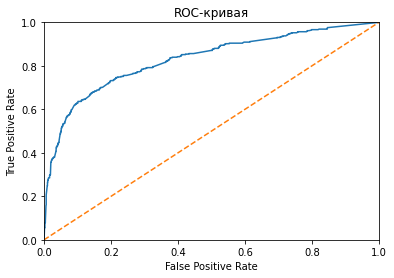

In [39]:
probabilities_valid = model_RFC_test.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC =', auc_roc)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

**ВЫВОД**

В первоначальной выборке был сильный дисбаланса, отрицательных ответов около 80%, а положительных всего 20%.

Мы устранили дисбаланс техникой upsampling и увеличили число положительных ответов в 4 раза

Лучше всего себя показала модель случайный лес, для которой подобрали лучшие гипперпараметры и избавились от дисбаланса

Случайный лес до баланса
- F1 мера: 0.6032210834553441
- Точность: 0.847
- Полнота: 0.49282296650717705
- AUC-ROC: 0.8408009666160574

Случайный лес после баланса
- F1 мера: 0.6257822277847309
- Точность: 0.8375
- Полнота: 0.5980861244019139
- AUC-ROC: 0.8294940387977183

После обучили тестовую модель, на сбалансированной выборке, она показала следующие результаты
- F1 мера: 0.606060606060606
- Точность: 0.8375
- Полнота: 0.19138755980861244
- AUC-ROC: 0.478616341739304

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*